# PDF Extraction

In [ ]:
import os
from PyPDF2 import PdfReader
from tqdm import tqdm
import pandas as pd

In [ ]:
pdfs_path = './data/pdfs'
data = []
for folder_name in os.listdir(pdfs_path):
    folder_path = os.path.join(pdfs_path, folder_name)

    if os.path.isdir(folder_path):
        for file_name in tqdm(os.listdir(folder_path), desc=f"Files in {folder_name}", leave=True):
            file_path = os.path.join(folder_path, file_name)
            
            if file_path.endswith('.pdf'):
                with open(file_path, 'rb') as file:
                    reader = PdfReader(file)
                    text = ''
                    for page in reader.pages:
                        text += page.extract_text().replace('\n', ' ')
                    data.append({'label': folder_name, 'resume': text})

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('data/extract.csv', index=False)

# Data Cleaning

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('./data/extract.csv')

In [ ]:
df.isnull().sum()

In [ ]:
df.describe(include='all')

In [ ]:
print(f"Before droppping NA resumes: {len(df)}")
df.dropna(inplace=True)
print(f"After dropping NA resumes: {len(df)}")

In [ ]:
print(f"Before droppping duplicate resumes: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"After dropping duplicate resumes: {len(df)}")

## Key notes:
1. 1 null resume
2. 2 duplicate resumes

# Data Preprocessing

## Setup

In [ ]:
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import spacy
from tqdm import tqdm

In [ ]:
nltk.download("stopwords")

In [ ]:
df = pd.read_csv('data/extract.csv')
nlp = spacy.load('en_core_web_lg')
STEMMER = SnowballStemmer(language='english') 
SCIKIT_STOPWORDS = text.ENGLISH_STOP_WORDS
NLTK_STOPWORDS = stopwords.words('english')

In [ ]:
def is_stopword(token):
   if(token.is_stop or \
      token.text in SCIKIT_STOPWORDS or \
      token.text in NLTK_STOPWORDS):
      return True
   else: 
      return False

## Researching

Listing how many stop words there are in each dictionary.

In [ ]:
print('Length of stop words')
print(f'Spacy: {len(nlp.Defaults.stop_words)}')
print(f'Scikit-learn: {len(SCIKIT_STOPWORDS)}')
print(f'NLTK: {len(NLTK_STOPWORDS)}')

nltk, scikit and spacy were used to filter out stop words from our data. \
**Note**: Punctuation and whitespaces will also be filtered out.

In [ ]:

doc = nlp('I am a dog running to outer space in the galaxy. hr HR bpo    BPO')

for token in doc:
    print(f'{token.text:{10}} {is_stopword(token)}')

**Note**: Punctuations, whitespaces and digits are not considered as alphabet

In [ ]:
doc = nlp('. , " ! $ % Andy    212    ')
for token in doc:
    print(f'{token.text:{10}} {token.is_alpha}')

**Note**: SnowballStemmer automatically lowercase the word

In [ ]:
words = ['Ant', 'B', 'Beekeeper', 'beekeeper', 'Zpp', 'Dog']
for word in words:
    print(f"{word} => {STEMMER.stem(word)}")

## Preprocessing

In [ ]:
def preprocess(txt):
   doc = nlp(txt)
   result = ''

   for token in doc:
      # Only non-entity words are allowed except stopwords
      if(token.is_alpha and \
         not is_stopword(token) and \
         not token.ent_type_):
         preprocessed_txt = STEMMER.stem(token.text)
         result += f'{preprocessed_txt} '

   return result

In [ ]:
cleaned_arr = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing Resumes"):
    txt = row['resume']
    cleaned_txt = preprocess(txt)
    cleaned_arr.append(cleaned_txt)

df['clean'] = cleaned_arr

In [ ]:
df['clean'][0]

In [ ]:
df.to_csv("data/cleaned.csv", index=False)

# Data Exploratory and Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('data/cleaned.csv')

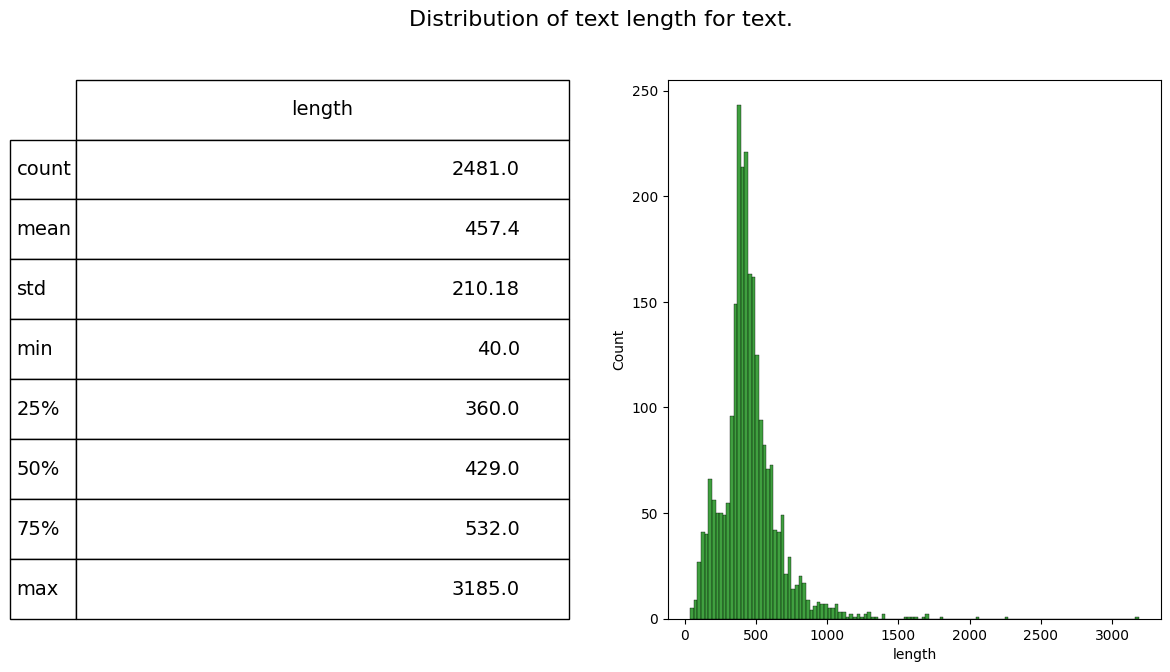

In [3]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

# fig = plt.gcf()
plt.show()

## Important Note
The histogram shows that the data has a right-skewed distribution. This distribution is very ineffective and costly when deep learning is implemented. Deep learning models like LSTM needs the inputs to be of the same size, so every instance of data has to be of the same length by either padding or truncating the data until it has the desired common length. Keeping the data with an extremely high word count and padding the rest of the data to this size will be very computationally expensive and inefficient. Instead of padding, truncating the data to the median for example will result to loss of information on a few data which might affect the models accuracy considering that the total count of our data is only 2481 to begin with. To ammend this, the top 15% longest data are removed.

In [4]:
df['word_length'] = df['clean'].str.split(' ')
df['word_length'] = df['word_length'].str.len()
df['word_length'].sort_values(ascending=False).head()

598     3186
1789    2259
1716    2049
1447    1806
273     1705
Name: word_length, dtype: int64

In [5]:
percentile_rightmost = df['word_length'].quantile(0.8)
percentile_leftmost = df['word_length'].quantile(0.15)
filtered_df = df[(df['word_length'] >= percentile_leftmost) & (df['word_length'] <= percentile_rightmost)]

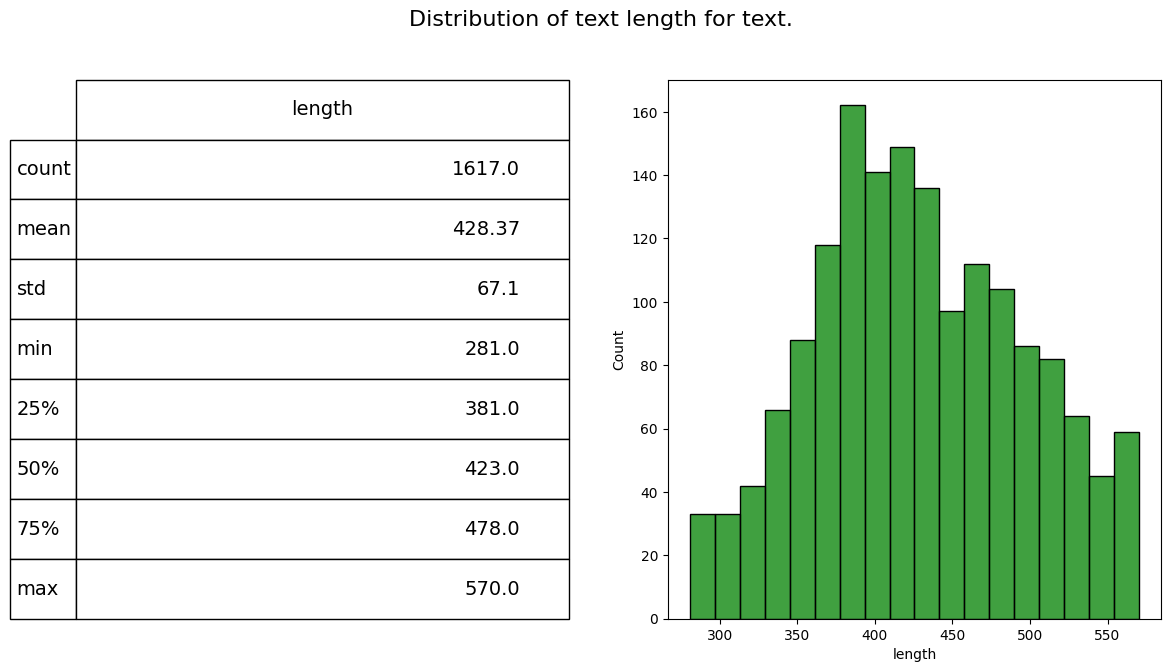

In [6]:
fig = plt.figure(figsize=(14,7))
df['length'] = filtered_df.clean.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()

In [ ]:
# Saving the data
filtered_df.to_csv("data/cleaned_15-80.csv", index=False)

In [7]:
print(f"Num of removed data: {len(df) - len(filtered_df)}")

Num of removed data: 864


In [ ]:
df = filtered_df
df.head()

In [ ]:
df.describe()

In [ ]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.show()

In [ ]:
count=df['label'].value_counts()
label=df['label'].value_counts().keys()

plt.figure(1, figsize=(25,25))
grid=GridSpec(2,2)

cmap=plt.get_cmap('coolwarm')

color=[cmap(i) for i in np.linspace(0, 1, 5)]
plt.subplot(grid[0,1], aspect=1, title='Distribution')

pie=plt.pie(count, labels=label, autopct='%1.2f%%')
plt.show()

In [ ]:
categories = np.sort(df['label'].unique())
df_categories = [df[df['label'] == category].loc[:, ['clean', 'label']] for category in categories]
df_categories[10]

In [ ]:
def generate_wordcloud(df):
    text = ' '.join(df['clean'])  # Assuming 'clean' column contains preprocessed text
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

In [ ]:
fig = plt.figure(figsize=(28, 64))

for i, category in enumerate(np.sort(df['label'].unique())):
    wordcloud = generate_wordcloud(df_categories[i])
    fig.add_subplot(12, 2, i + 1).set_title(category)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

plt.show()
plt.close()

# Classification Model

## Import  

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, SpatialDropout1D, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import pandas as pd

2024-05-15 23:17:35.337526: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 23:17:35.451951: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 23:17:35.837720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 23:17:35.839543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 23:17:37.464053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Creating model functions for deep learning

In [10]:
EMBEDDING_DIM = 500
MAX_WORDS = None    # define on each lstm model
TARGET_SIZE = 24
encoder = LabelEncoder()

def create_lstm(input_len, vocab_size=MAX_WORDS, embed_dim=EMBEDDING_DIM):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=input_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
    model.add(Dense(TARGET_SIZE, activation='softmax'))
    return model

def transform_and_split(X, y, input_len):
    # Encode y
    y_encoded = encoder.fit_transform(y)

    # Tokenize the input data
    tokenizer = Tokenizer(num_words=MAX_WORDS+1)
    tokenizer.fit_on_texts(X)
    X_sequences = tokenizer.texts_to_sequences(X)
    X_sequences_padded = pad_sequences(X_sequences, maxlen=input_len)

    y_encoded_dl = to_categorical(y_encoded, num_classes=TARGET_SIZE)
    
    # Split data
    XX_train, XX_test, y_train, y_test = train_test_split(X_sequences_padded, y_encoded_dl, test_size=0.2, random_state=42)

    vocab_size = len(tokenizer.word_index) + 1

    return XX_train, XX_test, y_train, y_test, vocab_size

def create_callbacks(path):
    checkpoint_callback = ModelCheckpoint(filepath=path, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

    early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

    reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

    return [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

## LSTM

In [3]:
df = pd.read_csv('data/cleaned.csv')
df['word_length'] = df['clean'].apply(lambda x: len(str(x).split()))

# max_length = df['word_length'].max() # too big ram would die
max_length = 1500

MAX_WORDS = 10000

X = df['clean']
y = df['label']
X_train, X_test_lstm, y_train, y_test_lstm, vocab_size = transform_and_split(X, y, max_length)

model_lstm = create_lstm(max_length, vocab_size=15000)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 500)         7500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 500)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               322048    
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 7,825,144
Trainable params: 7,825,144
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
batch_size = 128

history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_lstm,y_test_lstm), callbacks=create_callbacks("lstm_model.h5"))

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 3.1616 - accuracy: 0.0877
Epoch 1: val_accuracy improved from -inf to 0.04225, saving model to lstm_model.h5
16/16 [==============================] - 118s 7s/step - loss: 3.1616 - accuracy: 0.0877 - val_loss: 3.1489 - val_accuracy: 0.0423 - lr: 0.0010
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 3.0171 - accuracy: 0.1351
Epoch 2: val_accuracy improved from 0.04225 to 0.08652, saving model to lstm_model.h5
16/16 [==============================] - 113s 7s/step - loss: 3.0171 - accuracy: 0.1351 - val_loss: 3.0292 - val_accuracy: 0.0865 - lr: 0.0010
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 2.7944 - accuracy: 0.2041
Epoch 3: val_accuracy did not improve from 0.08652
16/16 [==============================] - 125s 8s/step - loss: 2.7944 - accuracy: 0.2041 - val_loss: 2.9831 - val_accuracy: 0.0825 - lr: 0.0010
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 2

## LSTM filtered


In [8]:
df = pd.read_csv('data/cleaned_15-80.csv')

MAX_WORDS = df['word_length'].max()

max_length = df['word_length'].max()

X = df['clean']
y = df['label']
X_train, X_test_lstm_15_80, y_train, y_test_lstm_15_80, vocab_size = transform_and_split(X, y, max_length)

model_lstm_15_80 = create_lstm(max_length, vocab_size=vocab_size)
model_lstm_15_80.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 571, 500)          6859000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 571, 500)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 128)               322048    
                                                                 
 dense_3 (Dense)             (None, 24)                3096      
                                                                 
Total params: 7,184,144
Trainable params: 7,184,144
Non-trainable params: 0
_________________________________________________________________


In [9]:
MAX_WORDS

571

In [12]:
vocab_size

13718

In [11]:
model_lstm_15_80.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
batch_size = 64

history_lstm_15_80 = model_lstm_15_80.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_lstm_15_80,y_test_lstm_15_80), callbacks=create_callbacks("lstm_model_15-80.h5"))

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 3.1590 - accuracy: 0.0936
Epoch 1: val_accuracy improved from -inf to 0.09877, saving model to lstm_model_15-80.h5
21/21 [==============================] - 29s 1s/step - loss: 3.1590 - accuracy: 0.0936 - val_loss: 3.1185 - val_accuracy: 0.0988 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 2.9780 - accuracy: 0.1330
Epoch 2: val_accuracy improved from 0.09877 to 0.12654, saving model to lstm_model_15-80.h5
21/21 [==============================] - 26s 1s/step - loss: 2.9780 - accuracy: 0.1330 - val_loss: 2.9426 - val_accuracy: 0.1265 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 2.8536 - accuracy: 0.2359
Epoch 3: val_accuracy improved from 0.12654 to 0.16358, saving model to lstm_model_15-80.h5
21/21 [==============================] - 28s 1s/step - loss: 2.8536 - accuracy: 0.2359 - val_loss: 2.8424 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 4/15
21/21 [=

# Conclusion and Result

## Setup

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def print_results(X_test, y_test, history, model):
    y_pred = model.predict(X_test)
    y_pred_prob = np.array(y_pred)  
    y_pred = np.argmax(y_pred_prob, axis=1)

    y_test_prob = np.array(y_test)  
    y_test_acc = np.argmax(y_test_prob, axis=1)

    print(f'Accuracy score: ', accuracy_score(y_test_acc, y_pred))

    results = model.evaluate(X_test, y_test, verbose=False)
    print(f'Test results - Loss: {results[0]} - Accuracy: {100*results[1]}%')
    

    acc = history.history['accuracy']                        
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot( acc, 'go', label='Train accuracy')
    plt.plot( val_acc, 'g', label='Validate accuracy')
    plt.title('Train and validate accuracy')
    plt.legend()                                           

    plt.figure()
    plt.plot( loss, 'go', label='Train loss')
    plt.plot( val_loss, 'g', label='Validate loss')
    plt.title('Train and validate loss')
    plt.legend()
    plt.show()

## LSTM 

In [ ]:
print_results(X_test_lstm, y_test_lstm, history_lstm, model_lstm)

## LSTM 15 - 80

11/11 [==============================] - 2s 176ms/step
Accuracy score:  0.2839506172839506
Test results - Loss: 2.5945634841918945 - Accuracy: 28.395062685012817%


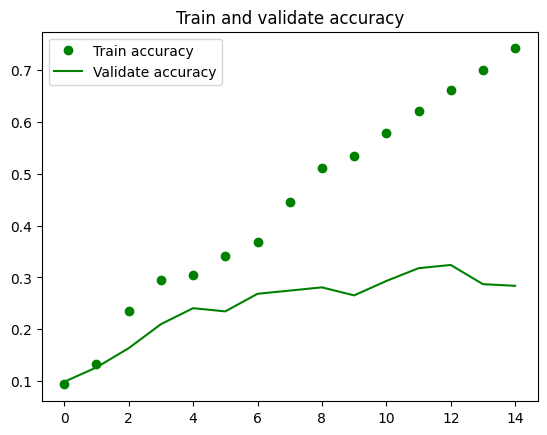

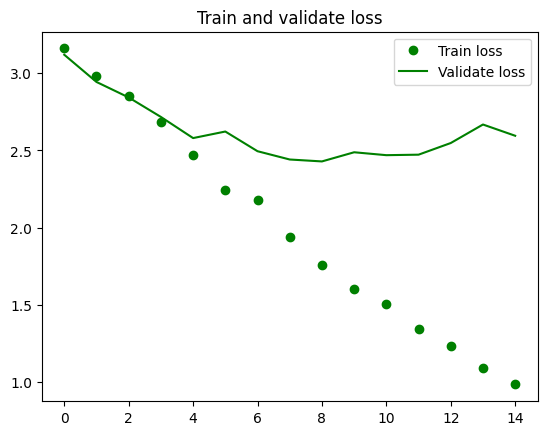

In [17]:
print_results(X_test_lstm_15_80, y_test_lstm_15_80, history_lstm_15_80, model_lstm_15_80)